# 02 — MODELLING NOTEBOOK

## 1. Load Cleaned Data
## 2. Feature Engineering
## 3. Split Into Train/Test
## 4. Build Preprocessing Pipeline
## 5. Create Helper Functions
## 6. Train Baseline Model
## 7. Cross-Validation & Confusion Matrix
## 8. PCA / t-SNE Visualizations
## 9. Precision–Recall / ROC Curves
## 10. SMOTE (Optional)
## 11. Learning Curve
## 12. Logistic Regression Solver Test
## 13. Hyperparameter Tuning (GridSearch)
## 14. Final Evaluation
## 15. Calibration Curve + Brier Score
## 16. Save Best Model


# 1. Load Cleaned Data


In [1]:
import os
import json

def create_model_dirs(model_name):
    """
    Creates folder structure:
    ../Reports/<model_name>/metrics/
    ../Reports/<model_name>/figures/
    """
    base = f"../Reports/{model_name}"
    metrics_dir = os.path.join(base, "metrics")
    figures_dir = os.path.join(base, "figures")

    os.makedirs(metrics_dir, exist_ok=True)
    os.makedirs(figures_dir, exist_ok=True)

    return metrics_dir, figures_dir


In [2]:
# Core
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder, label_binarize
from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder

# Model Selection
from sklearn.model_selection import (
    train_test_split, cross_val_score, cross_val_predict,
    learning_curve, GridSearchCV, StratifiedKFold
)

# Models
from sklearn.linear_model import LogisticRegression

# Pipeline
from sklearn.pipeline import Pipeline

# Metrics
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report, confusion_matrix,
    ConfusionMatrixDisplay, roc_curve, auc, precision_recall_curve,
    average_precision_score, brier_score_loss
)

# Dimensionality Reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Calibration
from sklearn.calibration import calibration_curve

# SMOTE
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline  # Note: separate pipeline for SMOTE

# Saving models
import joblib

# OS utilities
import os


In [3]:
import pickle

with open('../Data/Processed/cleaned_df.pkl', 'rb') as f:
    cleaned_df = pickle.load(f)

# 2. Feature Engineering

In [4]:
# y: 3-class target 
y = cleaned_df['readmitted'].map({
    'NO': 0,
    '>30': 1,
    '<30': 2
})

# X: all features (no target)
X = cleaned_df.drop(columns=['readmitted'])


In [5]:
#Age bins → numeric midpoints
age_map = {
    '[0-10)': 5,
    '[10-20)': 15,
    '[20-30)': 25,
    '[30-40)': 35,
    '[40-50)': 45,
    '[50-60)': 55,
    '[60-70)': 65,
    '[70-80)': 75,
    '[80-90)': 85,
    '[90-100)': 95
}
X['age'] = X['age'].map(age_map)

#Medications: No/Steady/Up/Down → 0/1/2/3 

medication_cols = [
    'insulin','metformin','acarbose','miglitol','nateglinide','chlorpropamide','repaglinide',
    'glyburide','glimepiride','glipizide','pioglitazone','acetohexamide',
    'tolbutamide','rosiglitazone','troglitazone','tolazamide','glyburide-metformin',
    'glimepiride-pioglitazone','metformin-rosiglitazone','metformin-pioglitazone','glipizide-metformin'

]
medication_mapping = {"No": 0, "Steady": 1, "Up": 2, "Down": 3}

for col in medication_cols:
    X[col] = X[col].map(medication_mapping)


In [6]:
numeric_cols = [
    'num_lab_procedures', 'num_medications', 'number_outpatient',
    'number_emergency', 'number_inpatient', 'number_diagnoses',
    'time_in_hospital', 'num_procedures', 'age', 'weight', 'discharge_disposition_id'
] + medication_cols   # meds are numeric now, so add them here

high_card_cols = ['diag_1_category', 'diag_2_category', 'diag_3_category', 'admission_source_id']

low_card_cols = ['admission_type_id', 'race', 'gender', 'A1Cresult', 'max_glu_serum']


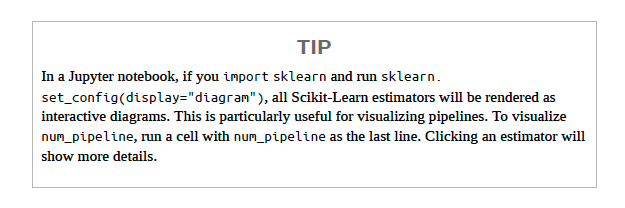

In [7]:
print(X.isna().sum().sort_values(ascending=False))
# Check target
print(y.value_counts())
# Check for missing values in X
print(X.isna().sum().sort_values(ascending=False).head(15))

race                        0
glimepiride                 0
glipizide                   0
glyburide                   0
tolbutamide                 0
pioglitazone                0
rosiglitazone               0
acarbose                    0
miglitol                    0
troglitazone                0
tolazamide                  0
insulin                     0
glyburide-metformin         0
glipizide-metformin         0
glimepiride-pioglitazone    0
metformin-rosiglitazone     0
metformin-pioglitazone      0
diag_1_category             0
diag_2_category             0
acetohexamide               0
chlorpropamide              0
gender                      0
nateglinide                 0
age                         0
weight                      0
admission_type_id           0
discharge_disposition_id    0
admission_source_id         0
time_in_hospital            0
num_lab_procedures          0
num_procedures              0
num_medications             0
number_outpatient           0
number_eme

# 3. Split Into Train/Test

In [8]:
#Test-Train split
from sklearn.model_selection import train_test_split
#The target y (readmitted) is imbalanced.
#So we should stratify based on the target variable.

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y, #maintains the same same class ratio as original dataset
    random_state=42
)


# 4. Build Preprocessing Pipeline

In [9]:

preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),                           # scale numeric
        ('low', OneHotEncoder(drop='first', handle_unknown='ignore'), low_card_cols),  # one-hot small categoricals
        ('high', TargetEncoder(), high_card_cols),                         # target encode big categoricals
    ],
    remainder='drop'
)

# 5. Create Helper Functions

In [11]:
# (A) Confusion Matrix
def plot_confusion_matrix_and_save(y_test, y_pred, model_name):
    _, figures_dir = create_model_dirs(model_name)

    plt.figure(figsize=(5,4))
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize="true")
    plt.title("Normalized Confusion Matrix")

    path = os.path.join(figures_dir, "confusion_matrix.png")
    plt.savefig(path, dpi=300, bbox_inches="tight")
    plt.close()
    print("Saved CM →", path)



In [12]:
# (B) PCA plot function
def plot_pca_and_save(model, X_test, y_test, model_name):
    _, figures_dir = create_model_dirs(model_name)

    X_trans = model.named_steps['prep'].transform(X_test)
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_trans)

    plt.figure(figsize=(7,6))
    for cls in np.unique(y_test):
        idx = y_test == cls
        plt.scatter(X_pca[idx,0], X_pca[idx,1], s=8, alpha=0.5, label=f"Class {cls}")

    plt.title("PCA Visualization")
    plt.legend()
    path = os.path.join(figures_dir, "pca.png")
    plt.savefig(path, dpi=300, bbox_inches="tight")
    plt.close()
    print("Saved PCA →", path)



In [13]:
# (C) t-SNE function
def plot_tsne_and_save(model, X_test, y_test, model_name="Model"):
    _, figures_dir = create_model_dirs(model_name)

    # Transform through preprocessing
    X_trans = model.named_steps['prep'].transform(X_test)

    # t-SNE embedding
    X_emb = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(X_trans)

    plt.figure(figsize=(7,6))

    for cls in np.unique(y_test):
        idx = (y_test == cls)
        plt.scatter(X_emb[idx, 0], X_emb[idx, 1], s=8, alpha=0.5, label=f"Class {cls}")

    plt.title("t-SNE Visualization")
    plt.legend()

    path = os.path.join(figures_dir, "tsne.png")
    plt.savefig(path, dpi=300, bbox_inches="tight")
    plt.close()

    print("Saved t-SNE plot →", path)



In [14]:
# (D) ROC curve function
def plot_multiclass_roc_and_save(model, X_test, y_test, model_name):
    _, figures_dir = create_model_dirs(model_name)

    if not hasattr(model, "predict_proba"):
        return

    y_proba = model.predict_proba(X_test)
    classes = np.unique(y_test)
    y_bin = label_binarize(y_test, classes=classes)

    plt.figure(figsize=(7,6))
    for i, cls in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_bin[:, i], y_proba[:, i])
        auc_val = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"Class {cls} (AUC={auc_val:.3f})")

    plt.plot([0,1],[0,1],"k--")
    plt.title("ROC Curves")
    plt.legend()

    path = os.path.join(figures_dir, "roc_curves.png")
    plt.savefig(path, dpi=300, bbox_inches="tight")
    plt.close()
    print("Saved ROC →", path)



In [15]:
# (E) PR curve function
def plot_multiclass_pr_and_save(model, X_test, y_test, model_name="Model"):
    _, figures_dir = create_model_dirs(model_name)

    if not hasattr(model, "predict_proba"):
        print("Model does not support predict_proba — skipping PR curves.")
        return

    y_score = model.predict_proba(X_test)
    classes = np.unique(y_test)
    y_test_bin = label_binarize(y_test, classes=classes)

    plt.figure(figsize=(7,5))

    for i, cls in enumerate(classes):
        prec, rec, _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
        plt.plot(rec, prec, label=f"Class {cls}")

    plt.title("Precision–Recall Curves (Multiclass)")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()

    path = os.path.join(figures_dir, "precision_recall_curves.png")
    plt.savefig(path, dpi=300, bbox_inches="tight")
    plt.close()

    print("Saved PR curves →", path)


### Types of Multiclass ROC/AUC & When to Use Them
1️⃣ Per-Class ROC (One-vs-Rest)

Computes one ROC curve for each class vs all other classes.

Shows how well the model separates each individual class.

Use when:

You want to understand which class performs poorly or well.

You want class-specific diagnostic information.

2️⃣ Micro-Average ROC/AUC

Flattens all class predictions into one big binary problem.

Counts all true positives / false positives across all classes.

Larger classes contribute more weight.

Interpretation:

Measures overall model performance across all samples.

Use when:

You have class imbalance and want a single global metric.

You care about performance on the entire dataset, not fairness.

3️⃣ Macro-Average ROC/AUC

Computes ROC for each class separately, then averages them.

Each class gets equal weight, no matter how many samples it has.

Interpretation:

Measures average performance per class.

Treats small and large classes equally.

Use when:

You want a balanced view across classes.

You care about how the model treats minority classes.

Your data is imbalanced and you want fairness.

In [16]:
# (F) Calibration Curve
def plot_calibration_and_save(model, X_test, y_test, model_name):
    metrics_dir, figures_dir = create_model_dirs(model_name)

    if not hasattr(model, "predict_proba"):
        return

    y_proba = model.predict_proba(X_test)
    classes = np.unique(y_test)

    plt.figure(figsize=(7,6))

    brier_scores = {}
    for i, cls in enumerate(classes):
        y_bin = (y_test == cls).astype(int)
        frac_pos, mean_pred = calibration_curve(y_bin, y_proba[:, i], n_bins=10)
        plt.plot(mean_pred, frac_pos, "o-", label=f"Class {cls}")

        brier_scores[str(cls)] = brier_score_loss(y_bin, y_proba[:, i])

    plt.plot([0,1],[0,1],"k--")
    plt.title("Calibration Curves")
    plt.legend()

    # Save figure
    path = os.path.join(figures_dir, "calibration_curves.png")
    plt.savefig(path, dpi=300, bbox_inches="tight")
    plt.close()

    # Save Brier scores
    with open(os.path.join(metrics_dir, "brier_scores.json"), "w") as f:
        json.dump(brier_scores, f, indent=4)

    print("Saved Calibration →", path)


In [17]:
# (G) Save metrics
from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix,
    classification_report, brier_score_loss
)

def save_metrics(model, y_test, y_pred, y_proba, model_name):
    metrics_dir, _ = create_model_dirs(model_name)

    metrics = {
        "accuracy": float(accuracy_score(y_test, y_pred)),
        "f1_macro": float(f1_score(y_test, y_pred, average="macro")),
        "confusion_matrix": confusion_matrix(y_test, y_pred).tolist(),
        "classification_report": classification_report(y_test, y_pred, output_dict=True)
    }

    if y_proba is not None:
        brier_scores = {}
        classes = sorted(list(set(y_test)))
        for i, cls in enumerate(classes):
            y_bin = (y_test == cls).astype(int)
            brier_scores[str(cls)] = float(brier_score_loss(y_bin, y_proba[:, i]))
        metrics["brier_scores"] = brier_scores

    with open(os.path.join(metrics_dir, "metrics.json"), "w") as f:
        json.dump(metrics, f, indent=4)

    print(f"Saved metrics → {metrics_dir}/metrics.json")


In [18]:
# (H) Learning Curve
def plot_learning_curve_and_save(model, model_name, X_train, y_train):
    """
    Computes and plots a learning curve, then saves it into the model-specific folder.
    """

    _, figures_dir = create_model_dirs(model_name)

    train_sizes, train_scores, val_scores = learning_curve(
        estimator=model,
        X=X_train,
        y=y_train,
        cv=5,
        scoring='accuracy',     # modify as needed
        train_sizes=np.linspace(0.1, 1.0, 6),
        n_jobs=-1
    )

    # Mean scores
    train_mean = train_scores.mean(axis=1)
    val_mean = val_scores.mean(axis=1)

    # Plot
    plt.figure(figsize=(7,5))
    plt.plot(train_sizes, train_mean, 'o-', label='Train Score')
    plt.plot(train_sizes, val_mean, 'o-', label='Validation Score')

    plt.xlabel("Training Set Size")
    plt.ylabel("Score")
    plt.title(f"Learning Curve — {model_name}")
    plt.legend()
    plt.grid(True)

    # Save
    path = os.path.join(figures_dir, "learning_curve.png")
    plt.savefig(path, dpi=300, bbox_inches="tight")
    plt.close()

    print("Saved learning curve →", path)


In [19]:
# (I) Run full evaluation
def run_full_evaluation(model, model_name, X_train, y_train, X_test, y_test):
    """
    Full evaluation pipeline for any model.
    Includes:
    - Predictions
    - Metrics saving
    - Confusion Matrix
    - PCA
    - t-SNE
    - ROC curves (if model supports predict_proba)
    - Precision–Recall curves (if model supports predict_proba)
    - Calibration curves (if model supports predict_proba)
    - Learning Curve
    """

    print(f"\n=== Running Evaluation for {model_name} ===")

    # Predictions
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test) if hasattr(model, "predict_proba") else None

    # ----- Save Metrics -----
    save_metrics(model, y_test, y_pred, y_proba, model_name)

    # ----- Core Plots -----
    plot_confusion_matrix_and_save(y_test, y_pred, model_name)
    plot_pca_and_save(model, X_test, y_test, model_name)
    plot_tsne_and_save(model, X_test, y_test, model_name)

    # ----- Probability-Based Plots -----
    if hasattr(model, "predict_proba"):
        plot_multiclass_roc_and_save(model, X_test, y_test, model_name)
        plot_multiclass_pr_and_save(model, X_test, y_test, model_name)
        plot_calibration_and_save(model, X_test, y_test, model_name)
    else:
        print("Model does not support predict_proba → Skipping ROC, PR, Calibration plots.")

    # ----- Learning Curve -----
    plot_learning_curve_and_save(model, model_name, X_train, y_train)

    print(f"=== Completed evaluation for {model_name} ===\n")


In [20]:
# (J) Run full model
def run_full_model_workflow(
    base_model,               
    model_name,               
    preprocess,               
    X_train, y_train,         
    X_test, y_test,
    run_cv=True,
    run_solver_test=False,
    run_gridsearch=False,
    grid_params=None,
    solver_list=None,
    run_final_eval=True
):
    """
    High-level flexible workflow for any ML model.
    """

    print(f"\n=========== {model_name}: Workflow Started ===========")

    # ---------------------------------------------------------
    # 1. Build Pipeline
    # ---------------------------------------------------------
    pipe = Pipeline([
        ('prep', preprocess),
        ('model', base_model)
    ])

    # ---------------------------------------------------------
    # 2. Cross-Validation
    # ---------------------------------------------------------
    if run_cv:
        print("\n--- Cross-Validation ---")
        cv_scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring='f1_macro')
        print("CV Scores:", cv_scores)
        print("CV Mean:", cv_scores.mean())

    # ---------------------------------------------------------
    # 3. Solver Test (for Logistic Regression only)
    # ---------------------------------------------------------
    if run_solver_test and solver_list:
        print("\n--- Logistic Regression Solver Test ---")
        for solver in solver_list:
            try:
                lr = LogisticRegression(
                    solver=solver,
                    max_iter=2000,
                    class_weight='balanced',
                    multi_class='ovr'
                )
                pipe_s = Pipeline([
                    ('prep', preprocess),
                    ('logreg', lr)
                ])
                pipe_s.fit(X_train, y_train)
                y_pred_s = pipe_s.predict(X_test)
                print(f"\nSolver: {solver}")
                print(classification_report(y_test, y_pred_s))
            except Exception as e:
                print(f"Solver {solver} failed: {e}")

    # ---------------------------------------------------------
    # 4. Hyperparameter Tuning (GridSearch)
    # ---------------------------------------------------------
    best_model = pipe
    if run_gridsearch and grid_params:
        print("\n--- GridSearch Hyperparameter Tuning ---")

        cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

        gs = GridSearchCV(
            pipe,
            param_grid=grid_params,
            scoring="f1_macro",
            cv=cv,
            refit=True,
            n_jobs=-1,
            verbose=1
        )

        gs.fit(X_train, y_train)
        print("\nBest Params:", gs.best_params_)
        print("Best CV f1_macro:", gs.best_score_)

        best_model = gs.best_estimator_

    else:
        # Fit baseline model
        best_model.fit(X_train, y_train)

    # ---------------------------------------------------------
    # 5. Final Evaluation + All Plots
    # ---------------------------------------------------------
    if run_final_eval:
        run_full_evaluation(
            model=best_model,
            model_name=model_name,
            X_train=X_train,
            y_train=y_train,
            X_test=X_test,
            y_test=y_test
        )

    print(f"=========== {model_name}: Workflow Completed ===========\n")

    return best_model


# 6. Train Baseline Model

In [21]:
logreg = LogisticRegression(class_weight='balanced', max_iter=2000)

solver_list = ["lbfgs", "saga", "newton-cg"]

grid_params = [
    {'model__penalty': ['l2'], 'model__C': [0.1, 1, 3], 'model__solver': ['lbfgs']},
    {'model__penalty': ['l1'], 'model__C': [0.01, 0.1, 1], 'model__solver': ['saga']},
]

best_lr = run_full_model_workflow(
    base_model=logreg,
    model_name="LogisticRegression",
    preprocess=preprocess,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    run_cv=True,
    run_solver_test=True,
    solver_list=solver_list,
    run_gridsearch=True,
    grid_params=grid_params,
    run_final_eval=True
)
  


=========== LogisticRegression: Workflow Started ===========

--- Cross-Validation ---
CV Scores: [0.41416773 0.41156346 0.41779186 0.41729986 0.41495675]
CV Mean: 0.41515593031632614

--- Logistic Regression Solver Test ---


/Users/iti/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(



Solver: lbfgs
              precision    recall  f1-score   support

           0       0.64      0.64      0.64     10973
           1       0.45      0.36      0.40      7109
           2       0.19      0.32      0.24      2272

    accuracy                           0.51     20354
   macro avg       0.43      0.44      0.43     20354
weighted avg       0.53      0.51      0.51     20354



/Users/iti/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/iti/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/iti/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/iti/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/iti/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in


Solver: saga
              precision    recall  f1-score   support

           0       0.64      0.64      0.64     10973
           1       0.45      0.35      0.40      7109
           2       0.19      0.32      0.24      2272

    accuracy                           0.51     20354
   macro avg       0.43      0.44      0.43     20354
weighted avg       0.53      0.51      0.51     20354


Solver: newton-cg
              precision    recall  f1-score   support

           0       0.64      0.64      0.64     10973
           1       0.45      0.36      0.40      7109
           2       0.19      0.32      0.24      2272

    accuracy                           0.51     20354
   macro avg       0.43      0.44      0.43     20354
weighted avg       0.53      0.51      0.51     20354


--- GridSearch Hyperparameter Tuning ---
Fitting 3 folds for each of 6 candidates, totalling 18 fits


/Users/iti/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/iti/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/iti/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/iti/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/iti/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/iti/miniconda3/lib/python3.12/site-packages/sklearn/linear_mode


Best Params: {'model__C': 3, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}
Best CV f1_macro: 0.4141078730425049

=== Running Evaluation for LogisticRegression ===
Saved metrics → ../Reports/LogisticRegression/metrics/metrics.json
Saved CM → ../Reports/LogisticRegression/figures/confusion_matrix.png
Saved PCA → ../Reports/LogisticRegression/figures/pca.png
Saved t-SNE plot → ../Reports/LogisticRegression/figures/tsne.png
Saved ROC → ../Reports/LogisticRegression/figures/roc_curves.png
Saved PR curves → ../Reports/LogisticRegression/figures/precision_recall_curves.png
Saved Calibration → ../Reports/LogisticRegression/figures/calibration_curves.png


/Users/iti/miniconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/iti/miniconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/iti/miniconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/iti/miniconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/iti/miniconda3/lib/python3.12/site-packages/sklearn/prepro

Saved learning curve → ../Reports/LogisticRegression/figures/learning_curve.png
=== Completed evaluation for LogisticRegression ===

=========== LogisticRegression: Workflow Completed ===========



<Figure size 500x400 with 0 Axes>

SMOTE (Optional)

### SMOTE

Another method to handle imbalanced target class is SMOTE

SMOTE = Synthetic Minority OverSampling Technique

It balances the dataset by creating new synthetic samples for the minority class based on existing samples — not duplicates

The model sees:
Class 0: █████████████████████████████████████████████████

Class 1: ██████████████████████████████

Class 2: ██████       ← model barely learns this

After SMOTE:

Class 0: ███████████████████

Class 1: ███████████████████

Class 2: ███████████████████  ← now learned fairly

from imblearn.pipeline import Pipeline

from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression

pipe = Pipeline(
    steps=[
        ('prep', preprocess),                # your ColumnTransformer
        ('smote', SMOTE(random_state=42)),   # oversample AFTER preprocessing
        ('logreg', LogisticRegression(max_iter=1000))
    ]
)

pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)

print(classification_report(y_test, y_pred)) 

print(confusion_matrix(y_test,y_pred))

#the accuracy and other metrics still remains the same this is because of recall of class 1 which is ~26%. 

#Will be sticking to the standard LR with class_weight='balanced'


## Save Best Model

In [ ]:
import joblib
joblib.dump(best, "../Outputs/Models/best_model.pkl")
print("Model saved.")

# Baseline modelling
Run logistic regression / decision tree etc as baseline.
# Advanced Modelling
i) Experiment with RandomForest, XGB, CatBoost, etc.
ii) Use cross-validation.
# Evaluation & Explainability
i) Produce ROC, confusion matrix, SHAP plots.
ii) Export visuals → reports/figures/.
iii) Compare models in summary table.
# Error Analysis
Inspect misclassifications by demographic or diagnosis.
# Final Reporting
i)Summarize insights, metrics, and limitations.
ii)Create final README, model card, and reflection.
